<a href="https://colab.research.google.com/github/ivoytov/manhattan/blob/master/momentum_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from typing import Tuple

### Data Sources ###
Loan data is from Bloomberg BVAL, based on end of day price valuation. Loan list is compiled by screening for:

1.   Active Loans
2.   First Lien Rank
3.   Incorporated in the U.S.
4.   Denominated in USD
5.   \>= $1B outstanding
6.   Non-Investment Grade Rating from either S&P *or* Moody's

The screen is run as of the last day of every quarter (3/31, 6/30, 9/30, and 12/31). Loans that mature or expire during a quarter are included in that quarterly period, but are removed from the screen for the following quarter.

### Data Format

* `loan_data` - Loan IDs are arranged as separate columns, with the first column containing the date index. Price is listed as values in XX.XX format (% of par). If price is unavailable, then #N/A is listed. Trading days only. There are two files, one for loans from 12-31-2018 to 10-15-2020 period, and one for the 12-31-2015 to 12-31-2018 period.

* `loan_desc` - Loan IDs are arranged in the first column, with subsequent columns containing metadata on the loan.

* `periods` - Quarters are listed as separate columns. Loan IDs from the above-mentioned screen are listed under the column header with the `as of` date.

In [149]:
# read in historical prices
prices_2020 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2020_stub.csv', parse_dates=['Dates'], index_col='Dates')
prices_2019_2020 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2019-2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2016_2018 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2016-2018.csv', parse_dates=['Dates'], index_col='Dates')
prices_2013_2015 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2013-2015.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2013_2015, prices_2016_2018, prices_2019_2020, prices_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)", prices.shape)
prices = prices.fillna(method="pad")

(# dates, # tickers) (2000, 1266)


Below is a price graph of the trading history of every loan that breached price of ~85 for the first time, for a 10 trading period before the breach and 10 day period after the breach. The mean is shown in thick blue. There is a slight upward momentum observed in loans that breach 85 for the following 5-7 trading days.

In [150]:
def plotPricesAfterBigMove(prices: pd.DataFrame, trgtPrice: float, priceRange: float = 2., bigMove: float = 3.,  numDays: int = 10) -> None:
  out = pd.DataFrame()
  for ticker in prices:
    close = prices[ticker]
    try:
      if bigMove > 0:
        t0 = close[(close.diff(periods=numDays) > bigMove) & (close > trgtPrice - priceRange) & (close < trgtPrice + priceRange)].index[0]
      else:
        t0 = close[(close.diff(periods=numDays) < bigMove) & (close > trgtPrice - priceRange) & (close < trgtPrice + priceRange)].index[0]
    except:
      # loan never met criteria, skip
      continue
    yx = close.iloc[close.index.get_loc(t0) - numDays:close.index.get_loc(t0) + numDays]
    yx.index = range(-numDays,len(yx.index)-numDays)
    out = pd.concat([out, yx], axis=1)
    
  out.plot(kind="line", legend=False, colormap="binary", linewidth=.3)  
  out.T.mean().plot(linewidth=3)

In [151]:
HOLD_DAYS = 10
BIG_MOVE = 3
LOOKBACK_DAYS = 10
TARGET_PRICES = [85, 90]
PRICE_RANGE=2

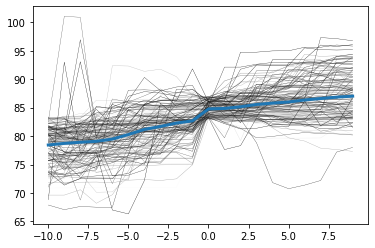

In [152]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[0], priceRange=PRICE_RANGE, bigMove=BIG_MOVE, numDays=LOOKBACK_DAYS)

Same analysis, but for loans that decline in price below 91. There is a stronger negative momentum effect, most likely due to a few cases that declined by 20% or more. The trend reverts sligtly after 5 days but is still meaningful.

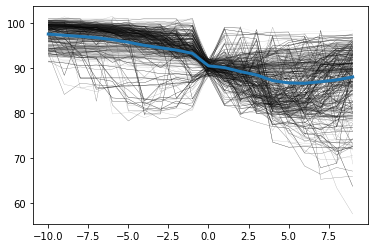

In [153]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[1], priceRange=PRICE_RANGE, bigMove=-BIG_MOVE, numDays=LOOKBACK_DAYS)

The trading strategy is to buy every loan that has appreciated by at least 3% (`BIG_MOVE`) and traded into 83-87 price range (`BUY_PRICE_RANGE`) and to short every loan that traded into 88-92 price range while declining by the big move amount. To calculate the decline, we compare the price from 10 days ago (`LOOKBACK_DAYS`) to today, and put the trade on in the following trading session. To smooth out and reduce amount of spurious trading, we use a geometric moving average of the price to determine the signal but with only a 2 day span (given the very short term nature of this signal, a longer span period means we miss the period when the alpha is realized). We hold the position for a maximum of 10 days (`HOLD_DAYS`) - unless the position moves by 3% in either direction, when we stop loss or take profit early.

In [154]:
def getLabels(prices: pd.DataFrame, trgtPrices: Tuple[float, float], priceRange: float = 2., lookbackDays: int = 10, bigMove: float = 3.) -> pd.DataFrame:
  prices_ma = prices.ewm(span=2).mean()
  price_chg = prices_ma.diff(periods=lookbackDays)
  buy = (price_chg.shift(1) > bigMove) & (prices > trgtPrices[0] - priceRange) & (prices < trgtPrices[0] + priceRange)
  sell = (price_chg.shift(1) < -bigMove) & (prices > trgtPrices[1] - priceRange) & (prices < trgtPrices[1] + priceRange)
  return buy*1.0 - sell*1.0

In [155]:
labels = getLabels(prices, trgtPrices=TARGET_PRICES, priceRange=PRICE_RANGE, lookbackDays=HOLD_DAYS, bigMove=BIG_MOVE)

Functions to:
* Generate labels between {-1, 0, 1} that mean we are short, neutral, or long the loan ID for that entire period

* Generate bins between {0, 1} that mean that the trade was good (\>$0 PNL, or `1`) or bad (negative PNL, or `0`) based on the side we picked in `labels` and the actual price change in the following period. Ignores interest income.

In [156]:
# triple barrier method function
# close:  a pandas series of prices
# events: a pandas dataframe wiht columns
#   - t1:   the timestamp of vertical barrier. When np.nan, no vertical barrier
#.  - trgt: the unit width of the horizontal barriers
# ptSl: a list of two non negative floats
#   - ptSl[0] the factor that multiplies trgt to set the width of the upper barrier. if 0, no upper barrier
#   - ptSl[1] the factor tha multiplesi trgt ot set the width of the lower barrier. if 0, no lower barrier
# molecule a list with the subset of event indices that will be processed by single thread

def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0]>0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) #NaNs

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index = events.index) #NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] #path prices
        df0 = (df0 / close[loc] -1) * events_.at[loc,'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min() # earliest profit taking
    return out

def getVertBarrier(gRaw, tEvents, numDays: int) -> pd.Series:
    t1 = gRaw.index.searchsorted(tEvents + pd.Timedelta(days = numDays))
    t1 = t1[t1 < gRaw.shape[0]]
    t1 = pd.Series(gRaw.index[t1], index=tEvents[:t1.shape[0]]) #NaNs at the end
    t1 = t1.rename('t1')
    return t1

def getBins(events: pd.DataFrame, close: pd.Series) -> pd.DataFrame:
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

# find the time of the first barrier touch
#  close: pandas series of prices
#  tEvents pandas timeindex of timestamps that will seed every ttriple barrier
#  ptSl a non negative flat that sets the width of th two barriers (symm)
# t1 pandas series with the timestamps of the vert barriers. pass false to disable
# trgt: pandas series of targets, expressed in terms of absolute returns
# minRet minimum target return required for running a triple barrier search
# numThreads  not used yet

# output:
# - t1: timestamp of when the first barrier is touched
# - trgt: the target that was used to generate the horizontal barrier

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents, dtype='datetime64')

    #3) form events object, apply stop loss on t1
    if side is None:
        side_ = pd.Series(1., index=trgt.index)
        ptSl_ = [ptSl, ptSl]
    else:
        side_ = side.loc[trgt.index]
        ptSl_ = ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_ }, axis = 1).dropna(subset=['trgt'])

    df0 = applyPtSlOnT1(close, events, ptSl_, events.index)
    events['t1'] = df0.dropna(how='all').apply(lambda x: x.min(),axis=1)
    if side is None:
        events = events.drop('side', axis = 1)
    events = events.dropna(subset=['t1'])
    return events

# daily vol, reindexed to close
def getDailyVol(close, span=14):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days = 1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0].values - 1 # daily returns
    df0 = df0.ewm(span=span).std().rename('trgt')
    return df0

def getBins(events, close):
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

The trading strategy is to observer trading prices of loans trading below 85 (`PRICE_RANGE`), when one of them gains 3 percent (`BIG_MOVE`) in any 5 day period (`LOOKBACK_DAYS`), then we buy the loan on the following days close. We hold the loan for 5 days (`HOLD_DAYS`) and sell. If the position moves in our favor or against us by 3%, then we stop loss or harvest early.

The `getBins` function returns a table of trade outcomes for each loan in {0,1} - 1 if trade made money, 0 if the trade lost money. 

In [157]:
out = pd.DataFrame()
for ticker in labels.columns:
  dates = labels[ticker][labels[ticker] != 0].index
  t1 = getVertBarrier(prices[ticker], dates, HOLD_DAYS)
  trgt = getDailyVol(prices[ticker])
  events = getEvents(prices[ticker], dates, ptSl=[.03,.03], trgt=trgt, minRet=0.015, numThreads=1, t1=t1, side=labels[ticker])
  bins = getBins(events, prices[ticker])
  bins['ticker'] = ticker   
  out = pd.concat([out, bins])

bins = out.set_index('ticker', append=True).swaplevel()
bins

ret         t1  bin  side
ticker   Dates                                     
BL101755 2016-12-01 -0.008415 2016-12-05  0.0  -1.0
BL055917 2014-10-17  0.007708 2014-10-20  1.0  -1.0
         2014-10-20 -0.005654 2014-10-21  0.0  -1.0
         2016-10-03  0.008863 2016-10-04  1.0   1.0
         2016-10-04  0.008059 2016-10-05  1.0   1.0
...                       ...        ...  ...   ...
BL323453 2020-03-18  0.009136 2020-03-19  1.0  -1.0
         2020-03-19  0.063875 2020-03-20  1.0  -1.0
         2020-03-26 -0.004819 2020-03-30  0.0  -1.0
         2020-03-27 -0.006206 2020-03-30  0.0  -1.0
         2020-03-30 -0.032241 2020-03-31  0.0  -1.0

[1904 rows x 4 columns]

Group the events by side and calculate how often the trade makes money. Both events triggered thousands of times so this is a robust sample - but do note that there is some overlap in the events. There were more long than short events. Most of the long trades generated a positive return, while it was roughly 50/50 for the short trades. 

In [158]:
pd.pivot_table(bins, index=['side'], columns=['bin'], values='ret', aggfunc=[len])

len       
bin     0.0    1.0
side              
-1.0  624.0  548.0
 1.0  302.0  430.0

Let's take a look at the types of return that each trade produces. The long trades generated a median return of 32 bps in the reasonably short holding period, while the short trades lost 47 bps. This is before trading fees, which on a $1B+ loan can be estimated at ~30 bps each side (60bps round trip).

In [159]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
-1.0,1172.0,0.004118,-0.006351,-0.000701,0.007810,0.507671,-0.098058,4.825878
1.0,732.0,0.004513,-0.002842,0.001486,0.006658,0.125006,-0.066322,3.303462


Plot the histogram of the returns from the long trades and then the short trades. We clip the histogram window at +/- 10% return to avoid showing the huge outliers.

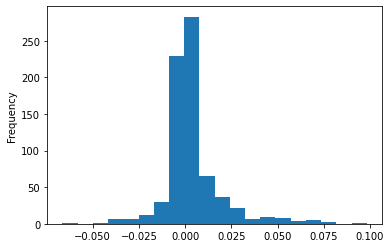

In [160]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

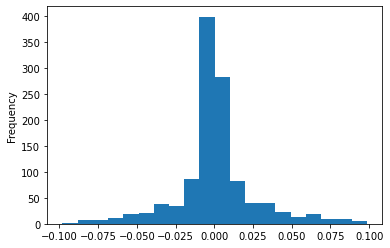

In [161]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

In [162]:
def getWeights(events, prices):
    numCoEvents = mpNumCoEvents(prices.index, events['t1'], events.index)
    numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
    numCoEvents = numCoEvents.reindex(prices.index).fillna(0)
    retW = mpSampleW(events['t1'], numCoEvents, prices, events.index)
    return getTimeDecay(retW, clfLastW=.5)
    
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed

    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1 = t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1 = t1[t1 >= molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(pd.to_datetime([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def mpSampleW(t1, numCoEvents, close, molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype='float64')
    for tIn,tOut in t1.loc[wght.index].iteritems():
        beg, end = ret.index.get_loc(tIn), ret.index.get_loc(tOut)
        wght.loc[tIn]=(ret.iloc[beg:end]/numCoEvents.iloc[beg:end]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    # if none of the weights are above zero, make sure the last weight is '1'
    if not clfW.iloc[-1]:
      clfW.iloc[-1] = 1
    if clfLastW>=0: 
        slope=(1.-clfLastW)/clfW.iloc[-1]
    else: 
        slope = 1./((clfLastW + 1) * clfW.iloc[-1])
    const=1. - slope * clfW.iloc[-1]
    clfW=const + slope * clfW
    clfW[clfW < 0] = 0
    return clfW

In [163]:
out = pd.DataFrame()
for ticker in bins.index.unique('ticker'):
    clfW = getWeights(bins.loc[ticker], prices[ticker])
    clfW.index = pd.MultiIndex.from_tuples([(ticker, a) for a in clfW.index], names=['ticker','Dates'])
    out = pd.concat([out, clfW])
out.columns = ['clfW']
bins = pd.concat([bins, out], axis=1)
bins

ret         t1  bin  side      clfW
ticker   Dates                                               
BL101755 2016-12-01 -0.008415 2016-12-05  0.0  -1.0  1.000000
BL055917 2014-10-17  0.007708 2014-10-20  1.0  -1.0  0.573606
         2014-10-20 -0.005654 2014-10-21  0.0  -1.0  0.582909
         2016-10-03  0.008863 2016-10-04  1.0   1.0  0.979743
         2016-10-04  0.008059 2016-10-05  1.0   1.0  0.990351
...                       ...        ...  ...   ...       ...
BL323453 2020-03-18  0.009136 2020-03-19  1.0  -1.0  0.634727
         2020-03-19  0.063875 2020-03-20  1.0  -1.0  0.653834
         2020-03-26 -0.004819 2020-03-30  0.0  -1.0  0.988543
         2020-03-27 -0.006206 2020-03-30  0.0  -1.0  0.991414
         2020-03-30 -0.032241 2020-03-31  0.0  -1.0  1.000000

[1904 rows x 5 columns]

## Incorporating loan information into the model

In [164]:
desc = pd.read_csv('/content/drive/MyDrive/loans/loans_desc.csv', parse_dates=['date_issued', 'maturity', ], index_col='id').rename_axis('ticker')
desc = desc.rename(columns={'ticker': 'name'})

In [165]:
# some basic data cleaning steps to make the data ready for the pipeline
desc = desc[['name', 'cpn', 'date_issued', 'maturity', 'amt_out', 'covi_lite', 'loan_type']]
desc.cpn = pd.to_numeric(desc.cpn, errors='coerce')
t = pd.Series({'Y': True, 'N': False})
desc.covi_lite = desc.covi_lite.map(t).astype(bool)
desc.maturity = pd.to_datetime(desc.maturity, errors='coerce')
desc.date_issued = pd.to_datetime(desc.date_issued, errors='coerce')
desc

,name,cpn,date_issued,maturity,amt_out,covi_lite,loan_type
ticker,,,,,,,
BL029150,HCA,150.0,2011-09-30,2022-06-28,3.750000e+09,False,ASSET-BASED REV
BL049152,CZR,525.0,2012-03-01,2017-03-01,5.469243e+09,False,TERM
BL055917,ARCH,450.0,2012-05-16,2018-05-16,1.950000e+09,True,TERM
BL078201,ABEGET,350.0,2012-10-18,2019-10-18,1.954560e+09,True,TERM
BL083751,ROYPHA,200.0,2012-11-02,2016-08-10,2.000000e+09,False,TERM
...,...,...,...,...,...,...,...
BL787561,TXU,350.0,2011-04-07,2014-10-10,2.263638e+10,False,TERM
LN333526,ENDENR,200.0,2007-05-01,2023-01-02,2.000000e+09,False,REV
LN365372,BBEP,NaN,2006-10-10,2019-11-19,1.400000e+09,False,RESERVE-BASED REV


## Training the model with loan features

In [166]:
df = bins.join(desc).drop(columns='name')
df

ret         t1  ...  covi_lite  loan_type
ticker   Dates                            ...                      
BL101755 2016-12-01 -0.008415 2016-12-05  ...       True       TERM
BL055917 2014-10-17  0.007708 2014-10-20  ...       True       TERM
         2014-10-20 -0.005654 2014-10-21  ...       True       TERM
         2016-10-03  0.008863 2016-10-04  ...       True       TERM
         2016-10-04  0.008059 2016-10-05  ...       True       TERM
...                       ...        ...  ...        ...        ...
BL323453 2020-03-18  0.009136 2020-03-19  ...       True       TERM
         2020-03-19  0.063875 2020-03-20  ...       True       TERM
         2020-03-26 -0.004819 2020-03-30  ...       True       TERM
         2020-03-27 -0.006206 2020-03-30  ...       True       TERM
         2020-03-30 -0.032241 2020-03-31  ...       True       TERM

[1904 rows x 11 columns]

In [167]:
class DayCounterAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
      X.maturity = (X.maturity - X.index.get_level_values('Dates')).dt.days
      X.date_issued = (X.index.get_level_values('Dates') - X.date_issued).dt.days
      return X

Process the data, train the model, output the most important features, and predict labels

In [168]:
def getIndMatrix(barIx, t1):
  # Get indicator matrix
  indM = pd.DataFrame(0, index=barIx, columns=range(t1.shape[0]))
  for i, (t0, t1) in enumerate(t1.iteritems()):
    t1 = (t1, t0[1])
    indM.loc[t0:t1, i] = 1.
  return indM

def getAvgUniqueness(indM):
  # average uniqueness from indicator matrix
  c = indM.sum(axis=1) # concurrency
  u = indM.div(c, axis=0) # uniqueness
  return u[u>0].mean().mean() # average uniqueness
  

def trainModel(num_attribs, cat_attribs, bool_attribs, df):
  num_pipeline = Pipeline([
      ('day_counter', DayCounterAdder()),
      ('imputer', SimpleImputer(strategy='median')),
      ('std_scaler', StandardScaler()),
  ])

  bin_pipeline = ColumnTransformer([
          ("cat", OneHotEncoder(), cat_attribs),
          ("num", num_pipeline, num_attribs),
          ("covi_lite", "passthrough", bool_attribs )
      ])

  df = df.swaplevel().sort_index()

  X = df.drop(columns=['bin', 'ret', 'clfW', 't1'])
  y = df[['bin', 'ret', 't1']]
  clfW = df.clfW
  avgU = getAvgUniqueness(getIndMatrix(X.index, y.t1))
  print("average feature uniqueness:", avgU)

  X_train_df, X_test_df, y_train, y_test, W_train, W_test = train_test_split(X, y, clfW, test_size=0.3, shuffle=False)
  X_train = bin_pipeline.fit_transform(X_train_df.copy())
  X_test = bin_pipeline.fit_transform(X_test_df.copy())

  #clf1 = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
  #rf = BaggingClassifier(base_estimator=clf1, n_estimators=1000, max_samples=avgU)

  clf2=RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
  rf = BaggingClassifier(base_estimator=clf2, n_estimators=1000, max_samples=avgU, max_features=1.)

  rf.fit(X_train, y_train.bin, W_train)
  print(f"Train Score: {rf.score(X_train, y_train.bin):2.2f}, Test Score: {rf.score(X_test, y_test.bin):2.2f}")
  y_pred_train, y_pred_test = rf.predict(X_train), rf.predict(X_test)
  y_score_train, y_score_test = rf.predict_proba(X_train)[:,1], rf.predict_proba(X_test)[:,1]

  cat_columns = [item for sublist in bin_pipeline.named_transformers_['cat'].categories_[1:] for item in sublist]
  columns = ['side_sell', 'side_buy', *cat_columns, 'cpn', 'date_issued', 'maturity', 'amt_out', 'covi_lite',]
  #print(*sorted(zip(rf.feature_importances_, columns), reverse=True), sep="\n")

  return X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test

Print out statistics on the training set

In [169]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out']
cat_attribs = ['side', 'loan_type']

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test = trainModel(num_attribs, cat_attribs, ['covi_lite'], df)

average feature uniqueness: 0.13939385904878573
Train Score: 0.82, Test Score: 0.53


Precision: 0.82, Recall: 0.84, Area under curve: 0.82
[[510 131]
 [113 578]]


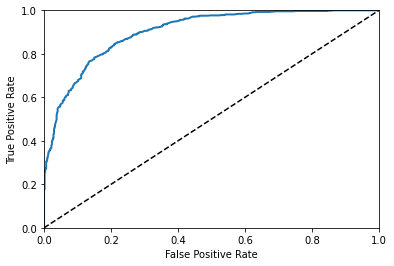

In [170]:
def printCurve(X, y, y_pred, y_score):
  print(f"Precision: {precision_score(y, y_pred):2.2f}, Recall: {recall_score(y, y_pred):2.2f}, Area under curve: {roc_auc_score(y, y_pred):2.2f}")
  print(confusion_matrix(y, y_pred))

  fpr, tpr, thresholds = roc_curve(y, y_score)

  def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

  plot_roc_curve(fpr, tpr)
  plt.show()

printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

Statistics on the testing set show that the meta-labeling model is just a toss up at predicting which trade to take or not - we need more metadata about each loan and event to accurately predict this.

Precision: 0.52, Recall: 0.83, Area under curve: 0.53
[[ 67 218]
 [ 49 238]]


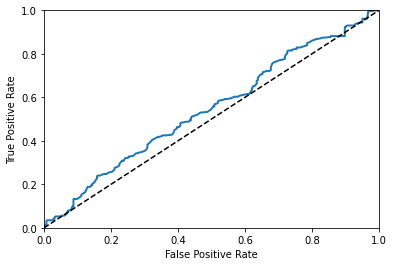

In [171]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

# Ratings

Let's improve our model by incorporating ratings on our loans. We have S&P and Moody's corporate ratings on each borrower. Our data is sampled quarterly, so we can only assign a rating for each event that was current as of the previous quarter end.

In [172]:
moody = pd.read_csv('/content/drive/MyDrive/loans/loans_moody.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('moody')
snp = pd.read_csv('/content/drive/MyDrive/loans/loans_snp.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('snp')
moody.index.set_levels(pd.PeriodIndex(pd.to_datetime(moody.index.levels[0]), freq='M'), level=0, inplace=True)
snp.index.set_levels(pd.PeriodIndex(pd.to_datetime(snp.index.levels[0]), freq='M'), level=0, inplace=True)
print(moody.unique(), snp.unique())

[nan 'B2' 'Ba3' 'B1' 'Baa2' 'Ba2' 'Caa1' 'Baa3' 'Caa3' '(P)Ba2' 'Ba1' 'B3'
 '(P)Ba1' '(P)Ba3' 'Caa2' 'WR' 'A3' '(P)B1' 'NR' '(P)Baa2' 'Ca' '(P)Baa3'
 '(P)B2' 'Baa1' 'A2' 'C' 'B2u'] ['BB' 'B' nan 'B+' 'BB-' 'BB+' 'B-' 'BBB-' 'BBB' 'CCC' 'CCC+' 'CCC-' 'CC'
 'NR' 'A' 'D' 'A-' 'BB+u' '(P)BB-' 'BBB+' 'C' '(P)B+']


In [173]:
moody_scale = {
    'A1': 1,
    'A2': 1,
    'A3': 1,
    'Baa1': 2,
    'Baa2': 2,
    '(P)Baa2': 2,
    'Baa3': 2,
    '(P)Baa3': 2,
    'Ba1': 3,
    'Ba1u': 3,
    '(P)Ba1': 3,
    '(P)Ba2': 3,
    'Ba2': 3,
    'Ba2u': 3,
    '(P)Ba3': 3,
    'Ba3': 3,
    'B1': 4,
    '(P)B1': 4,
    'B2':  5,
    'B2u': 5,
    '(P)B2': 5,
    'B3': 6,
    'Caa1': 7,
    'Caa2' : 7,
    'Caa3': 7,
    'Ca': 7,
    'C': 7,
}

snp_scale = {
    'A+': 1,
    'A': 1,
    'A-': 1,
    'BBB+': 2,
    'BBB': 2,
    'BBB-': 2,
    'BB+': 3,
    'BB+u': 3,
    'BB': 3,
    'BB-': 3,
    '(P)BB-': 3,
    'B+': 4,
    '(P)B+': 4,
    'B': 5,
    'B-': 6,
    'CCC+': 7,
    'CCC': 7,
    'CCC-': 7,
    'CC': 7,
    'C': 7,
    'D': 7,
}

moody_num = moody.map(moody_scale).fillna(5)
snp_num = snp.map(snp_scale).fillna(5)
avg_rating = pd.concat([moody_num,snp_num],axis=1).mean(axis=1).rename('avg_rating')

In [174]:
df_rating = df.reset_index(level='ticker')
df_rating['month'] = pd.PeriodIndex(df_rating.index, freq='M') - 1
df_rating = df_rating.set_index('ticker', append=True).swaplevel()
df_rating = df_rating.join(avg_rating, on=['month', 'ticker'])
df_rating

ret         t1  bin  ...  loan_type    month  avg_rating
ticker   Dates                                 ...                                
BL101755 2016-12-01 -0.008415 2016-12-05  0.0  ...       TERM  2016-11         4.0
BL055917 2014-10-17  0.007708 2014-10-20  1.0  ...       TERM  2014-09         4.0
         2014-10-20 -0.005654 2014-10-21  0.0  ...       TERM  2014-09         4.0
         2016-10-03  0.008863 2016-10-04  1.0  ...       TERM  2016-09         6.0
         2016-10-04  0.008059 2016-10-05  1.0  ...       TERM  2016-09         6.0
...                       ...        ...  ...  ...        ...      ...         ...
BL323453 2020-03-18  0.009136 2020-03-19  1.0  ...       TERM  2020-02         2.5
         2020-03-19  0.063875 2020-03-20  1.0  ...       TERM  2020-02         2.5
         2020-03-26 -0.004819 2020-03-30  0.0  ...       TERM  2020-02         2.5
         2020-03-27 -0.006206 2020-03-30  0.0  ...       TERM  2020-02         2.5
         2020-03-30 -0.032241 2020-03-31  0.0  ...       TERM  2020-02         2.5

[1904 rows x 13 columns]

In [175]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out']
cat_attribs = ['side', 'loan_type', 'avg_rating']

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test = trainModel(num_attribs, cat_attribs, ['covi_lite'], df_rating)

average feature uniqueness: 0.13939385904878573
Train Score: 0.81, Test Score: 0.52


Precision: 0.80, Recall: 0.84, Area under curve: 0.81
[[497 144]
 [111 580]]


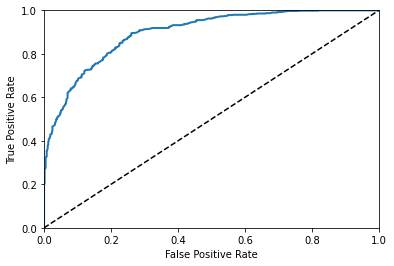

In [176]:
printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

As a result of adding credit ratings, the accuracy of the labeling model did not improve

Precision: 0.51, Recall: 0.82, Area under curve: 0.52
[[ 62 223]
 [ 52 235]]


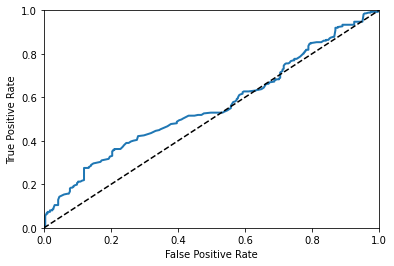

In [177]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

# Bond Dataset

In [178]:
# read in historical prices
prices_2019_2020 = pd.read_csv('/content/drive/MyDrive/bonds/bonds_data_2019_2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2017_2018 = pd.read_csv('/content/drive/MyDrive/bonds/bonds_data_2017_2018.csv', parse_dates=['Dates'], index_col='Dates')
prices_2015_2016 = pd.read_csv('/content/drive/MyDrive/bonds/bonds_data_2015_2016.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2015_2016, prices_2017_2018, prices_2019_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)", prices.shape)
prices = prices.fillna(method="pad")

(# dates, # tickers) (1533, 702)


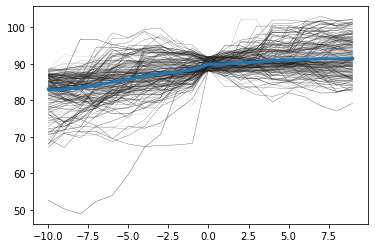

In [179]:
TARGET_PRICES = [90, 100]
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[0], priceRange=PRICE_RANGE, bigMove=BIG_MOVE, numDays=LOOKBACK_DAYS)

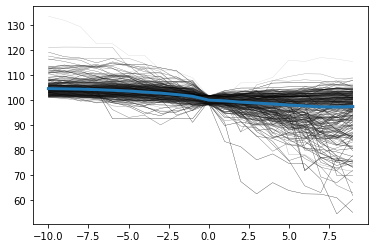

In [180]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[1], priceRange=PRICE_RANGE, bigMove=-BIG_MOVE, numDays=LOOKBACK_DAYS)

In [181]:
labels = getLabels(prices, trgtPrices=TARGET_PRICES, priceRange=PRICE_RANGE, lookbackDays=HOLD_DAYS, bigMove=BIG_MOVE)

In [182]:
out = pd.DataFrame()
for ticker in labels.columns:
  dates = labels[ticker][labels[ticker] != 0].index
  t1 = getVertBarrier(prices[ticker], dates, HOLD_DAYS)
  trgt = getDailyVol(prices[ticker])
  events = getEvents(prices[ticker], dates, ptSl=[.03,.03], trgt=trgt, minRet=0.015, numThreads=1, t1=t1, side=labels[ticker])
  bins = getBins(events, prices[ticker])
  bins['ticker'] = ticker   
  out = pd.concat([out, bins])

bins = out.set_index('ticker', append=True).swaplevel()
bins

ret         t1  bin  side
ticker   Dates                                     
EJ379173 2015-02-17  0.004340 2015-02-18  1.0   1.0
         2015-02-18 -0.004819 2015-02-19  0.0   1.0
EK474593 2015-02-06 -0.001260 2015-02-09  0.0   1.0
         2015-02-17  0.007605 2015-02-18  1.0   1.0
         2015-02-18 -0.016436 2015-02-19  0.0   1.0
...                       ...        ...  ...   ...
BK256707 2020-11-02 -0.023381 2020-11-03  0.0  -1.0
         2020-11-03 -0.028419 2020-11-04  0.0  -1.0
BK912979 2020-09-17  0.002057 2020-09-18  1.0  -1.0
         2020-09-18  0.013854 2020-09-21  1.0  -1.0
BK731780 2020-11-03 -0.015129 2020-11-04  0.0  -1.0

[2084 rows x 4 columns]

In [183]:
pd.pivot_table(bins, index=['side'], columns=['bin'], values='ret', aggfunc=[len])

len       
bin     0.0    1.0
side              
-1.0  414.0  381.0
 1.0  561.0  728.0

In [184]:
pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
-1.0,795.0,0.003669,-0.008504,-0.000000,0.011005,0.244127,-0.106211,2.916675
1.0,1289.0,0.003172,-0.005025,0.001771,0.010098,0.130367,-0.102533,4.088382


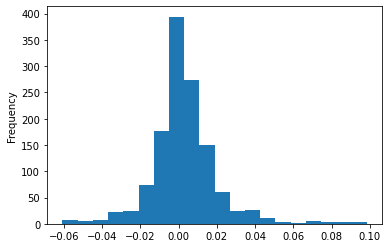

In [185]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

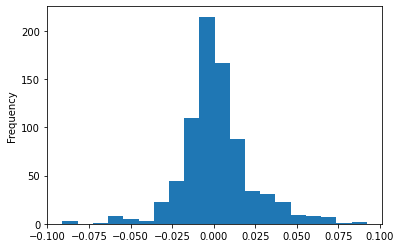

In [186]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

In [187]:
out = pd.DataFrame()
for ticker in bins.index.unique('ticker'):
    clfW = getWeights(bins.loc[ticker], prices[ticker])
    clfW.index = pd.MultiIndex.from_tuples([(ticker, a) for a in clfW.index], names=['ticker','Dates'])
    out = pd.concat([out, clfW])
out.columns = ['clfW']
bins = pd.concat([bins, out], axis=1)
bins

ret         t1  bin  side      clfW
ticker   Dates                                               
EJ379173 2015-02-17  0.004340 2015-02-18  1.0   1.0  0.891124
         2015-02-18 -0.004819 2015-02-19  0.0   1.0  1.000000
EK474593 2015-02-06 -0.001260 2015-02-09  0.0   1.0  0.624713
         2015-02-17  0.007605 2015-02-18  1.0   1.0  0.739330
         2015-02-18 -0.016436 2015-02-19  0.0   1.0  0.771307
...                       ...        ...  ...   ...       ...
BK256707 2020-11-02 -0.023381 2020-11-03  0.0  -1.0  0.820394
         2020-11-03 -0.028419 2020-11-04  0.0  -1.0  1.000000
BK912979 2020-09-17  0.002057 2020-09-18  1.0  -1.0  0.930281
         2020-09-18  0.013854 2020-09-21  1.0  -1.0  1.000000
BK731780 2020-11-03 -0.015129 2020-11-04  0.0  -1.0  1.000000

[2084 rows x 5 columns]

## Incorporating Bond Metadata into the Dataset

In [188]:
desc = pd.read_csv('/content/drive/MyDrive/bonds/bonds_desc.csv', parse_dates=['date_issued', 'maturity', ], index_col='id').rename_axis('ticker')
desc = desc.rename(columns={'ticker': 'name'})

In [189]:
# some basic data cleaning steps to make the data ready for the pipeline
desc = desc[['name', 'cpn', 'date_issued', 'maturity', 'amt_out']]
desc.cpn = pd.to_numeric(desc.cpn, errors='coerce')
desc.maturity = pd.to_datetime(desc.maturity, errors='coerce')
desc.date_issued = pd.to_datetime(desc.date_issued, errors='coerce')
desc

,name,cpn,date_issued,maturity,amt_out
ticker,,,,,
EK718211,SNEC,6.125,2015-01-23,2023-01-15,1150000000
QZ888409,RAX,8.625,2016-10-25,2024-11-15,1200000000
AR871586,MDR,10.625,2018-04-04,2024-05-01,1300000000
JK964020,FTR,11.000,2016-04-28,2025-09-15,3598050000
AP362087,WSTC,8.500,2017-10-03,2025-10-15,1150000000
...,...,...,...,...,...
EH880957,TWC,6.750,2009-06-24,2039-06-15,1500000000
EG874835,TWC,6.550,2007-09-25,2037-05-01,1500000000
EI807807,TWC,5.500,2011-09-07,2041-09-01,1250000000


In [190]:
df = bins.join(desc).drop(columns='name')
df

ret         t1  ...   maturity     amt_out
ticker   Dates                            ...                       
EJ379173 2015-02-17  0.004340 2015-02-18  ... 2019-05-15  1200000000
         2015-02-18 -0.004819 2015-02-19  ... 2019-05-15  1200000000
EK474593 2015-02-06 -0.001260 2015-02-09  ... 2024-11-15  2250000000
         2015-02-17  0.007605 2015-02-18  ... 2024-11-15  2250000000
         2015-02-18 -0.016436 2015-02-19  ... 2024-11-15  2250000000
...                       ...        ...  ...        ...         ...
BK256707 2020-11-02 -0.023381 2020-11-03  ... 2030-07-15  1000000000
         2020-11-03 -0.028419 2020-11-04  ... 2030-07-15  1000000000
BK912979 2020-09-17  0.002057 2020-09-18  ... 2030-09-01  1500000000
         2020-09-18  0.013854 2020-09-21  ... 2030-09-01  1500000000
BK731780 2020-11-03 -0.015129 2020-11-04  ... 2028-08-15  1775000000

[2084 rows x 9 columns]

## Train model with bond features

In [191]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out']
cat_attribs = ['side',]

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test = trainModel(num_attribs, cat_attribs, [], df)

average feature uniqueness: 0.19273654505085128
Train Score: 0.82, Test Score: 0.53


Precision: 0.83, Recall: 0.84, Area under curve: 0.82
[[562 132]
 [125 639]]


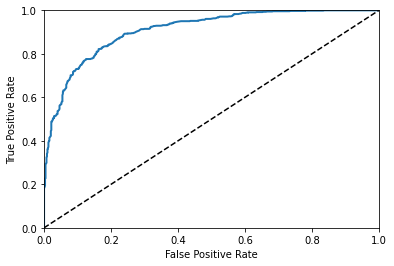

In [192]:
printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

Precision: 0.55, Recall: 0.79, Area under curve: 0.50
[[ 58 223]
 [ 74 271]]


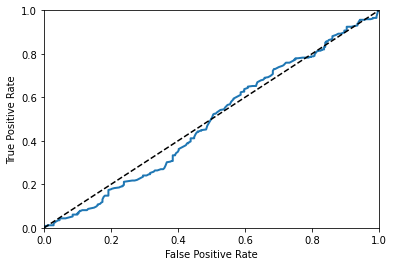

In [193]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

## Incorporating ratings into the model

In [194]:
moody = pd.read_csv('/content/drive/MyDrive/bonds/bonds_moody.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('moody')
#snp = pd.read_csv('/content/drive/MyDrive/bonds/bonds_snp.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('snp')
moody.index.set_levels(pd.PeriodIndex(pd.to_datetime(moody.index.levels[0]), freq='M'), level=0, inplace=True)
#snp.index.set_levels(pd.PeriodIndex(pd.to_datetime(snp.index.levels[0]), freq='M'), level=0, inplace=True)
print(moody.unique()) #, snp.unique())

['B3' nan 'Baa2' 'Ba1' 'Caa1' 'B2' 'Baa3' 'A1' 'Ba3' 'B1' 'Ba2' 'Baa1'
 '(P)Baa2' 'A3' 'A2' 'Ca' 'WR' 'Caa2' 'Caa3' 'C' '(P)Ba2' 'Ba2u' 'Ba1u']


In [195]:
moody_num = moody.map(moody_scale).fillna(5)
#snp_num = snp.map(snp_scale).fillna(5)
avg_rating = pd.concat([moody_num,],axis=1).mean(axis=1).rename('avg_rating')

In [198]:
df_rating = df.reset_index(level='ticker')
df_rating['month'] = pd.PeriodIndex(df_rating.index, freq='M') - 1
df_rating = df_rating.set_index('ticker', append=True).swaplevel()
df_rating = df_rating.join(avg_rating, on=['month', 'ticker'])
df_rating

ret         t1  bin  ...     amt_out    month  avg_rating
ticker   Dates                                 ...                                 
EJ379173 2015-02-17  0.004340 2015-02-18  1.0  ...  1200000000  2015-01         NaN
         2015-02-18 -0.004819 2015-02-19  0.0  ...  1200000000  2015-01         NaN
EK474593 2015-02-06 -0.001260 2015-02-09  0.0  ...  2250000000  2015-01         NaN
         2015-02-17  0.007605 2015-02-18  1.0  ...  2250000000  2015-01         NaN
         2015-02-18 -0.016436 2015-02-19  0.0  ...  2250000000  2015-01         NaN
...                       ...        ...  ...  ...         ...      ...         ...
BK256707 2020-11-02 -0.023381 2020-11-03  0.0  ...  1000000000  2020-10         NaN
         2020-11-03 -0.028419 2020-11-04  0.0  ...  1000000000  2020-10         NaN
BK912979 2020-09-17  0.002057 2020-09-18  1.0  ...  1500000000  2020-08         NaN
         2020-09-18  0.013854 2020-09-21  1.0  ...  1500000000  2020-08         NaN
BK731780 2020-11-03 -0.015129 2020-11-04  0.0  ...  1775000000  2020-10         NaN

[2084 rows x 11 columns]

In [200]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out']
cat_attribs = ['side', 'avg_rating']

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test = trainModel(num_attribs, cat_attribs, [], df_rating)

average feature uniqueness: 0.19273654505085128


ValueError: ignored